In [1]:
from tqdm import tqdm

from lib import mutation, plot

from lib.dataloader import load_data
from lib.solver import Solver
from lib.temperature import exponential
from lib.task import make_tasks
from lib.util import solve

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
data = load_data('../all')

big_data = sorted([df for df in data.values() if len(df['trace']) >= 200], key=lambda df: len(df['trace']))
big_tasks = make_tasks(big_data)
top10 = big_tasks[-10:]

  1%|          | 462/52967 [00:00<01:45, 499.74it/s]

100%|██████████| 52967/52967 [01:39<00:00, 529.81it/s]


In [4]:
mutations = [
    mutation.conditional(
        mutation.AssignRandomIdleCandidateToRandomRouteTillImpossible,
        epoch_predicat=lambda epoch: epoch == 0
    ),
    mutation.conditional(
        mutation.MakeRoomForRandomCandidate,
        epoch_predicat=lambda epoch: epoch != 0 and epoch % 5 == 0
    ),
    mutation.TryRecallRandomBusyCandidate,
    mutation.AssignRandomIdleCandidateToRandomRouteIfPossible,
    mutation.TryAssignRandomIdleCandidateToRandomRoute,
    mutation.TryAssignRandomIdleCandidateToRandomRoute,
]

solver = Solver(None, mutations, 'all')

In [5]:
solve(solver, *top10,
    epoches=10000,
    temp=exponential(2000, 1.01),
    retries=10,
    tqdm=tqdm,
    beamsreach_size=2,
)

100%|██████████| 10/10 [33:40<00:00, 202.01s/it]


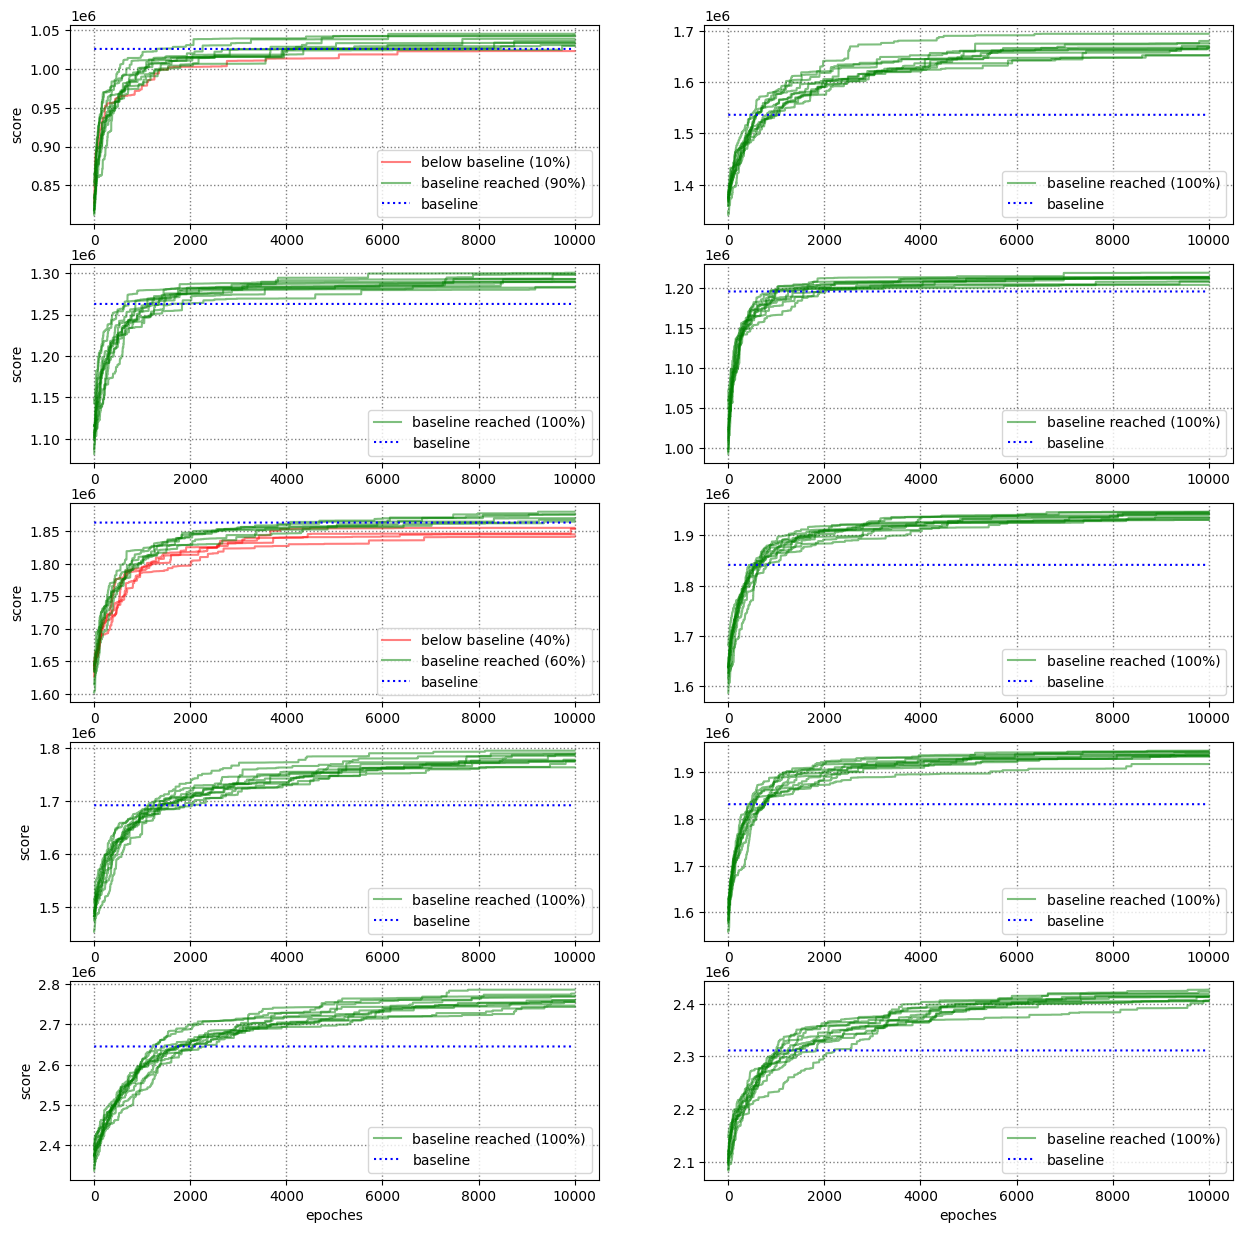

In [6]:
plot.solve_history(*top10, exclude_init=True)

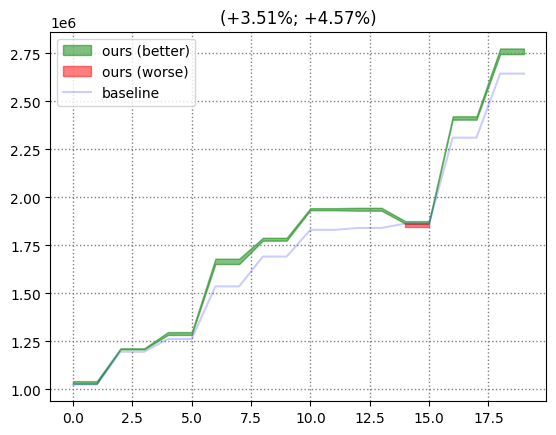

In [7]:
plot.total_diff_interval(*top10, confidence_interval=(0.1, 0.9))

In [8]:
solve(solver, *big_tasks,
    epoches=10000,
    temp=exponential(2000, 1.01),
    tqdm=tqdm,
    beamsreach_size=2,
)

100%|██████████| 997/997 [3:35:03<00:00, 12.94s/it]  


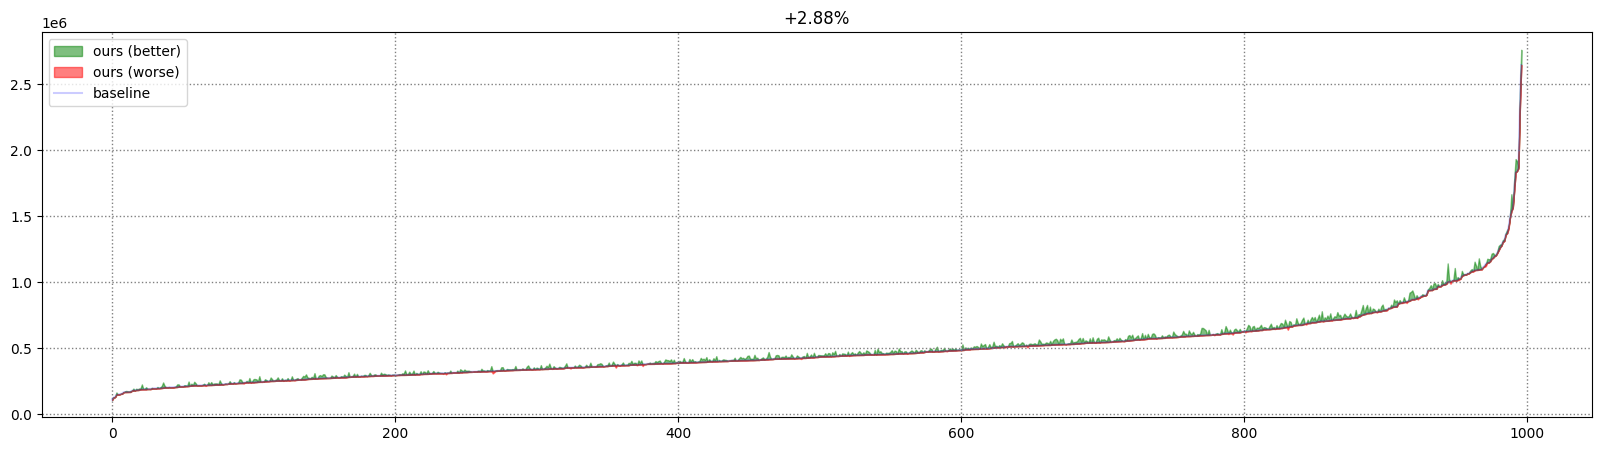

In [9]:
plot.total_diff(*big_tasks, last_n=1, figsize=(20, 5))